In [1]:
!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/Kaggle/kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c house-prices-advanced-regression-techniques -p Dataset

     |████████████████████████████████| 74 kB 2.9 MB/s 
     |████████████████████████████████| 4.2 MB 32.4 MB/s 
     |████████████████████████████████| 149 kB 57.5 MB/s 
     |████████████████████████████████| 112 kB 52.5 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 
  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-uwxtz_pl/lxml_999a59092dea42c59d1d42b99c3f9b3c/setup.py'"'"'; __file__='"'"'/tmp/pip-install-uwxtz_pl/lxml_999a59092dea42c59d1d42b99c3f9b3c/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-y8i2x10f/install-record.txt --s

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('/content/Dataset/train.csv')
test = pd.read_csv('/content/Dataset/test.csv')

train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


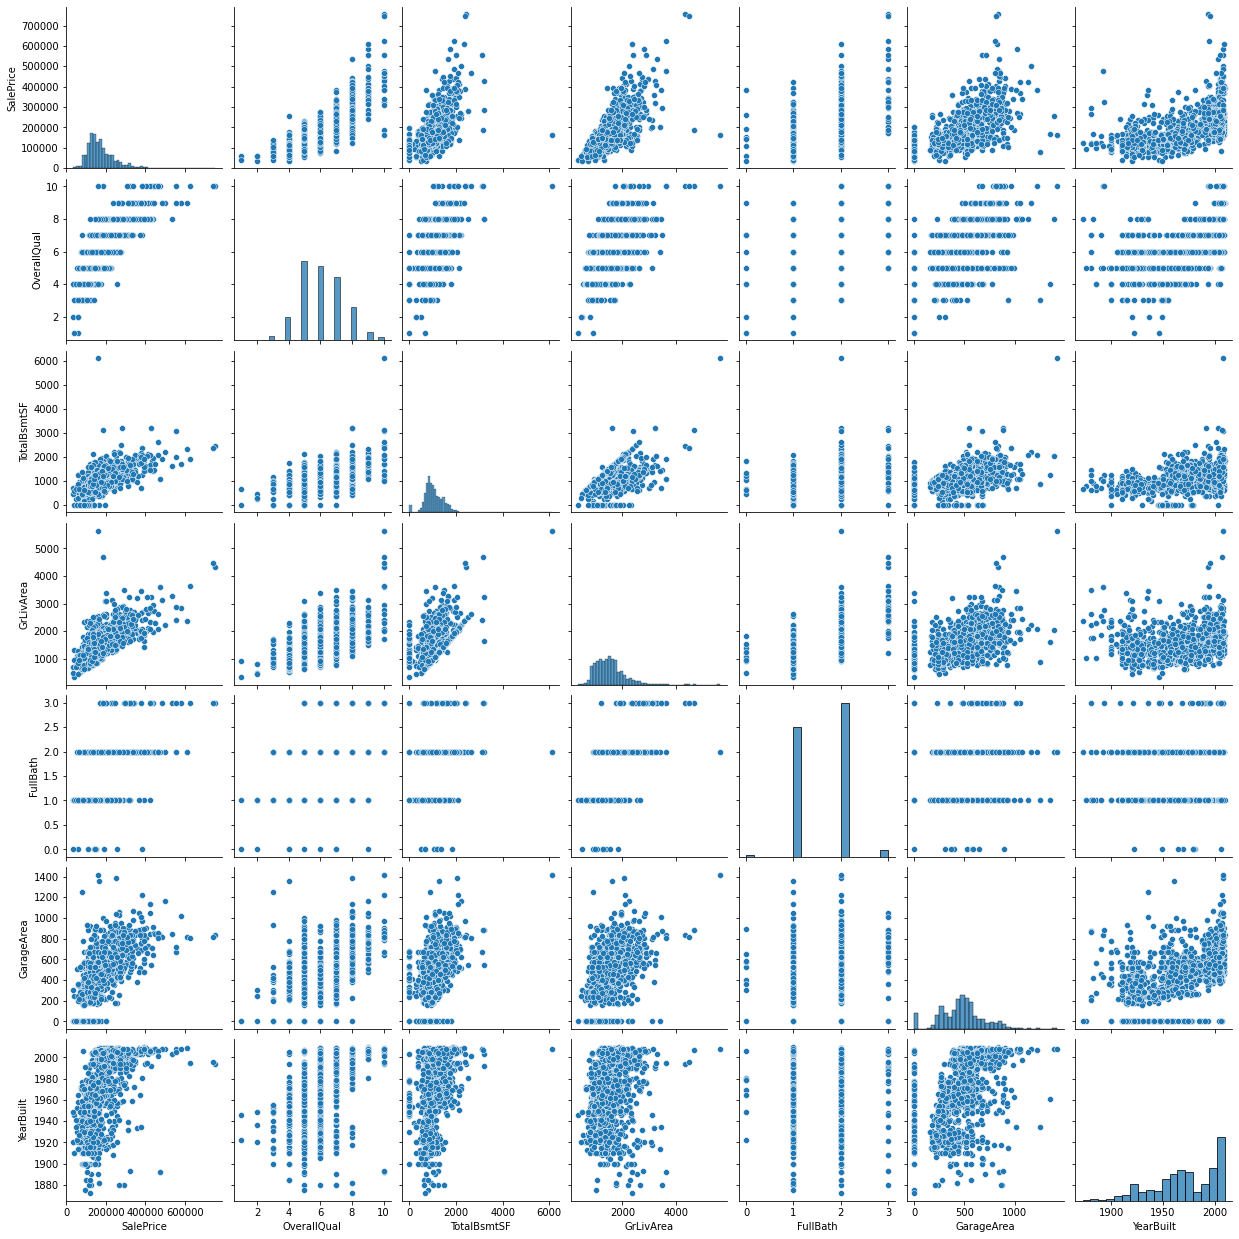

In [5]:
features = ['SalePrice', 'OverallQual', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'GarageArea', 'YearBuilt']
sns.pairplot(train[features], size = 2.5)
plt.show()

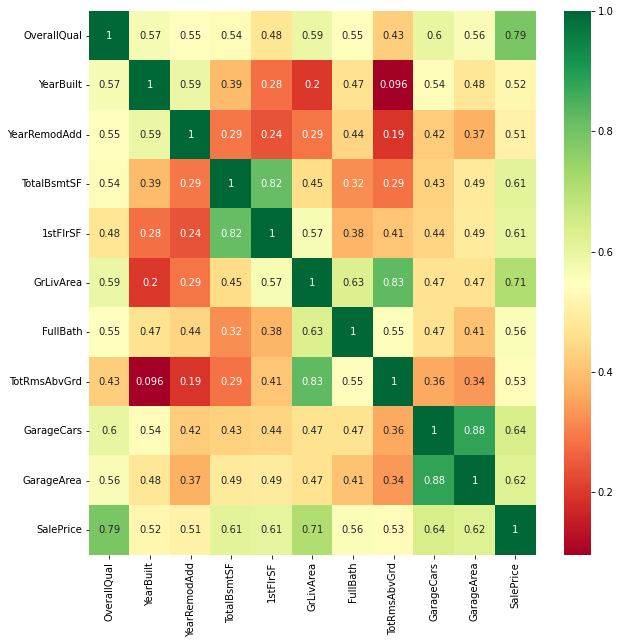

In [7]:
corr_map = train.corr()
corr_features = corr_map.index[abs(corr_map['SalePrice']) > 0.5]
plt.figure(figsize = (10,10))
sns.heatmap(train[corr_features].corr(), annot = True, cmap = "RdYlGn");

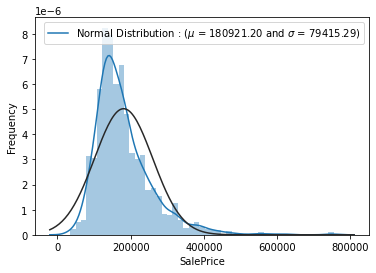

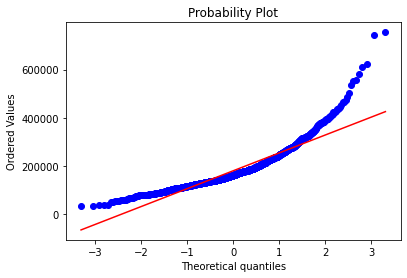

In [8]:
from scipy.stats.stats import sigmaclip
from scipy import stats
from scipy.stats import norm, skew

#train['SalePrice'] = np.expm1(train['SalePrice'])

sns.distplot(train['SalePrice'], fit=norm)

mu, sigma = norm.fit(train['SalePrice'])
plt.legend(['Normal Distribution : ($\mu$ = {:.2f} and $\sigma$ = {:.2f})'.format(mu, sigma)], loc = 'best')
plt.ylabel('Frequency')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

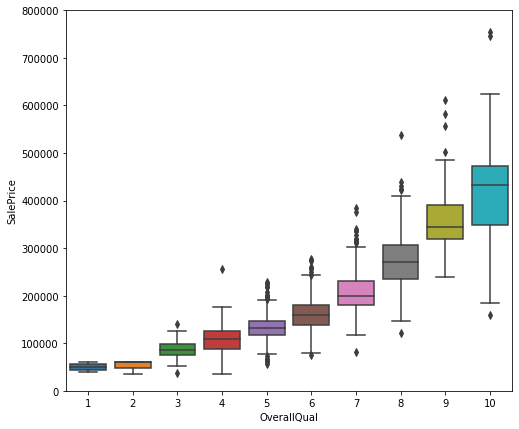

In [9]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
fig, ax = plt.subplots(figsize = (8,7))
fig = sns.boxplot(x = train['OverallQual'], y = train['SalePrice'], data=data)
fig.axis(ymin = 0, ymax = 800000);

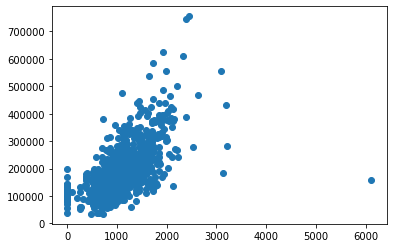

In [10]:
data = pd.concat([train['SalePrice'], train['TotalBsmtSF']], axis=1)
plt.scatter(x = 'TotalBsmtSF', y = 'SalePrice', data=data)
plt.show()

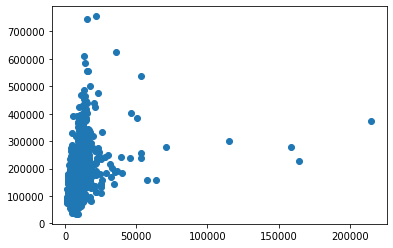

In [11]:
data = pd.concat([train['SalePrice'], train['LotArea']], axis=1)
plt.scatter(x = 'LotArea', y = 'SalePrice', data=data)
plt.show()

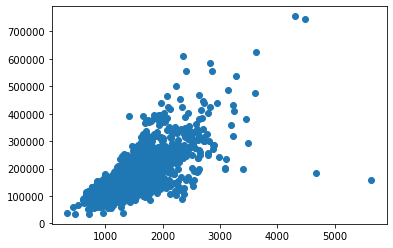

In [12]:
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
plt.scatter(x = 'GrLivArea', y = 'SalePrice', data=data)
plt.show()

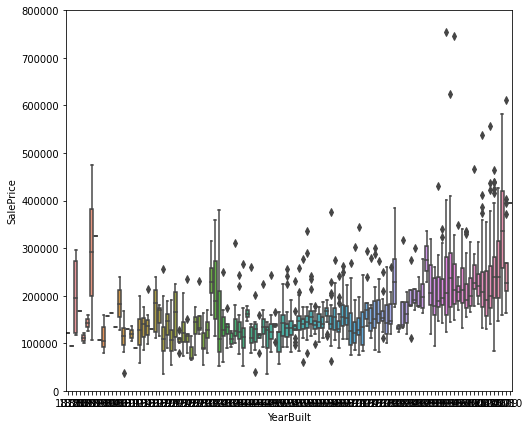

In [13]:
data = pd.concat([train['SalePrice'], train['YearBuilt']], axis=1)
fig, ax = plt.subplots(figsize = (8,7))
fig = sns.boxplot(x = train['YearBuilt'], y = train['SalePrice'])
fig.axis(ymin = 0, ymax = 800000);

In [14]:
train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

train.shape, test.shape

((1460, 80), (1459, 79))

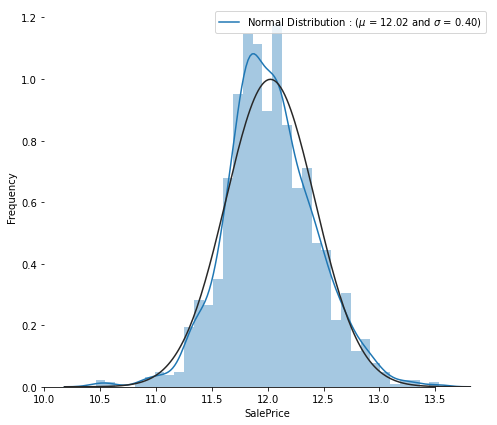

In [15]:
train['SalePrice'] = np.log1p(train['SalePrice'])

f, ax = plt.subplots(figsize = (8,7))
sns.distplot(train['SalePrice'], fit=norm)

mu, sigma = norm.fit(train['SalePrice'])
plt.legend(['Normal Distribution : ($\mu$ = {:.2f} and $\sigma$ = {:.2f})'.format(mu, sigma)], loc = 'best')
ax.set(xlabel = 'SalePrice')
ax.set(ylabel = 'Frequency')
ax.xaxis.grid(False)
sns.despine(left=True, trim=True)
plt.show()

In [16]:
train.drop(train[(train['OverallQual'] < 5) & (train['SalePrice'] > 200000)].index, inplace=True)
train.drop(train[(train['GrLivArea'] > 4200) & (train['SalePrice'] < 300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

In [17]:
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2915, 79)

In [18]:
def percent_missing(df):
  data = pd.DataFrame(df)
  d_cols = list(pd.DataFrame(data))
  dict_ret = {}
  for i in range(0, len(d_cols)):
    dict_ret.update({d_cols[i]: round(data[d_cols[i]].isnull().mean()*100, 2)}) 
  
  return dict_ret

missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key = lambda x: x[1], reverse=True)
print("Percent of Missing Values :\n")
df_miss[:10]


Percent of Missing Values :



[('PoolQC', 99.73),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.45),
 ('FireplaceQu', 48.71),
 ('LotFrontage', 16.67),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45),
 ('GarageCond', 5.45)]

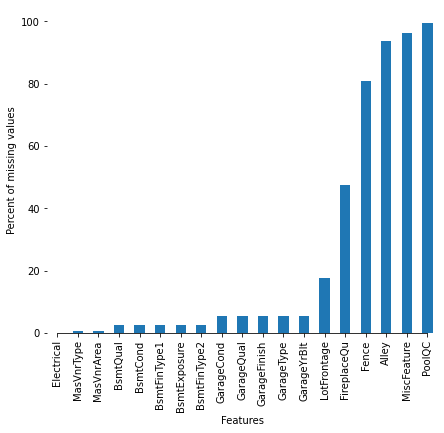

In [19]:
f, ax = plt.subplots(figsize=(7,6))
missing = round(train.isnull().mean()*100, 2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
ax.set(xlabel="Features")
ax.set(ylabel="Percent of missing values")
ax.xaxis.grid(False)
sns.despine(left=True, trim=True)

In [20]:
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)

In [21]:
def handle_missing(features):
  features['Functional'] = features['Functional'].fillna('Typ')
  features['Electrical'] = features['Electrical'].fillna('SBrkr')
  features['KitchenQual'] = features['KitchenQual'].fillna('TA')
  features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
  features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
  features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
  features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].fillna(features['MSZoning'].mode()[0])

  features['PoolQC'] = features['PoolQC'].fillna('None')
  for col in ('GarageYrBlt', 'GarageCars', 'GarageArea'):
    features[col] = features[col].fillna(0)

  for col in ('GarageType', 'GarageCond', 'GarageQual', 'GarageFinish'):
    features[col] = features[col].fillna('None')

  for col in ('BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond'):
    features[col] = features[col].fillna('None')

  features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x : x.fillna(x.median()))
  
  objects = []
  for i in features.columns:
    if(features[i].dtype == 'object'):
      objects.append(i)
  features.update(features[objects].fillna('None'))

  numerics = []
  numeric_list = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  for i in features.columns:
    if(features[i].dtype in numeric_list):
      numerics.append(i)
  features.update(features[numerics].fillna(0))

  return features


all_features = handle_missing(all_features)
all_features['MSZoning'] = all_features['MSZoning'].astype(object)

In [22]:
missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key = lambda x: x[1], reverse=True)
print("Percent of Missing Values :\n")
df_miss[:10]

Percent of Missing Values :



[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0)]

In [23]:
numerics = []
numeric_list = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
for i in all_features.columns:
  if(all_features[i].dtype in numeric_list):
    numerics.append(i)


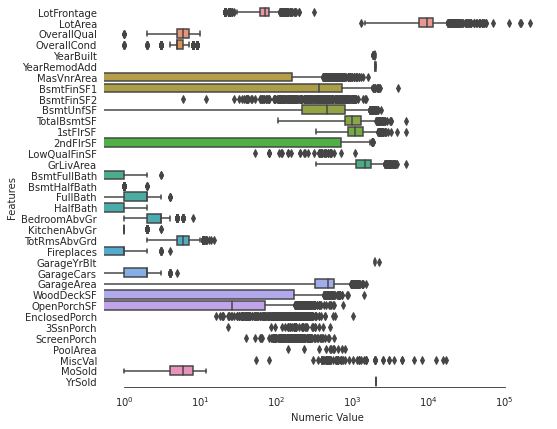

In [24]:
sns.set_style('white')
f, ax = plt.subplots(figsize=(8,7))
ax.set_xscale('log')
sns.boxplot(data = all_features[numerics], orient='h')
ax.set(xlabel='Numeric Value')
ax.set(ylabel='Features')
ax.xaxis.grid(False)
sns.despine(left=True, trim=True)

In [25]:
skew_features = all_features[numerics].apply(lambda x: x.skew()).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print('There are {} features with high skew'.format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew': skew_features})
skew_features[:10]

There are 25 features with high skew


MiscVal          21.943440
PoolArea         18.711459
LotArea          13.130516
LowQualFinSF     12.086535
3SsnPorch        11.373947
KitchenAbvGr      4.301059
BsmtFinSF2        4.144996
EnclosedPorch     4.002856
ScreenPorch       3.945539
BsmtHalfBath      3.944922
dtype: float64

In [26]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
for i in skew_index:
  all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

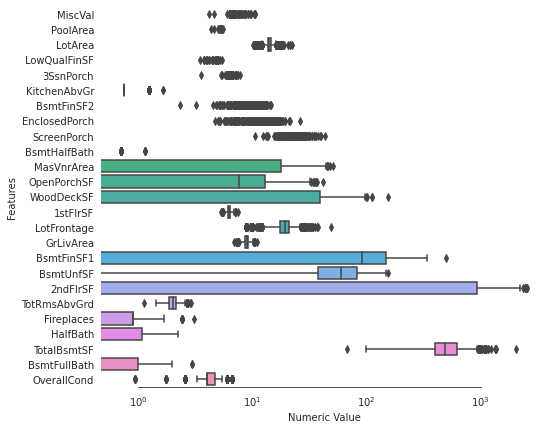

In [27]:
sns.set_style('white')
f, ax = plt.subplots(figsize=(8,7))
ax.set_xscale('log')
sns.boxplot(data = all_features[skew_index], orient='h')
ax.set(xlabel='Numeric Value')
ax.set(ylabel='Features')
ax.xaxis.grid(False)
sns.despine(left=True, trim=True)

In [28]:
X = all_features[numerics]
X_train = X.iloc[:len(train_labels), :]
X_test = X.iloc[len(train_labels): 2*len(train_labels), :]
y_train = train_labels
y_test = train_labels
X_test.shape, y_test.shape, X_train.shape

((1456, 35), (1456,), (1456, 35))

In [29]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
  pred = cross_val_score(model, X_train, y_train, cv=10)
  return pred.mean()

def print_evaluate(true, predicted):
  mae = metrics.mean_absolute_error(true, predicted)
  mse = metrics.mean_squared_error(true, predicted)
  rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
  r2squared = metrics.r2_score(true, predicted)
  print("MAE:", mae)
  print("MSE:", mse)
  print("RMSE:", rmse)
  print("R2 Square:", r2squared)
  print('----------------------------')

def evaluate(true, predicted):
  mae = metrics.mean_absolute_error(true, predicted)
  mse = metrics.mean_squared_error(true, predicted)
  rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
  r2squared = metrics.r2_score(true, predicted)
  return mae, mse, rmse, r2squared


In [30]:
X.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('std_scalar', StandardScaler())])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)


In [32]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train, y_train)


LinearRegression(normalize=True)

In [33]:
lin_reg.intercept_

12.021949506725813

In [34]:
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
LotFrontage,0.004854
LotArea,0.041871
OverallQual,0.099340
OverallCond,0.057228
YearBuilt,0.090404
YearRemodAdd,0.022801
MasVnrArea,-0.000708
BsmtFinSF1,0.008863
BsmtFinSF2,-0.011647
BsmtUnfSF,-0.026527


In [35]:
pred = lin_reg.predict(X_test)

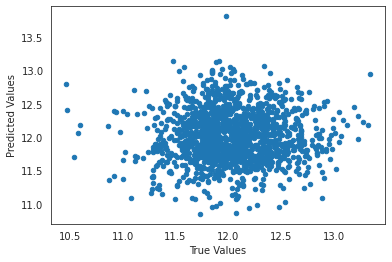

In [36]:
pd.DataFrame({"True Values" : y_test, "Predicted Values": pred}).plot.scatter(x='True Values', y='Predicted Values');

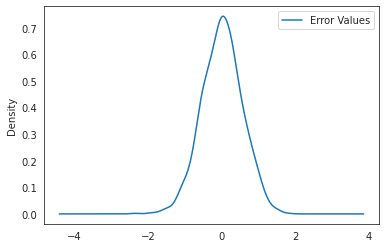

In [37]:
pd.DataFrame({"Error Values": (y_test - pred)}).plot.kde();

In [38]:
train_pred = lin_reg.predict(X_train)
test_pred = lin_reg.predict(X_test)

print("Train Set Predictions are:\n----------------------------")
print_evaluate(y_train, train_pred)
print("Test Set Predictions are:\n----------------------------")
print_evaluate(y_test, test_pred)

Train Set Predictions are:
----------------------------
MAE: 0.08399321802107389
MSE: 0.014494868056963943
RMSE: 0.1203946346685098
R2 Square: 0.9075402202063966
----------------------------
Test Set Predictions are:
----------------------------
MAE: 0.4329396348188188
MSE: 0.3000780329574581
RMSE: 0.5477937868919819
R2 Square: -0.91413600586825
----------------------------


In [39]:
results_df = pd.DataFrame(data = [["Linear Regression", *evaluate(y_test, test_pred), cross_val(LinearRegression())]], columns = ["Model", "MAE", "MSE", "RMSE", "R2 Square", "Cross Validation"])
results_df


,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.43294,0.300078,0.547794,-0.914136,0.901226


In [40]:
from sklearn.linear_model import RANSACRegressor

model = RANSACRegressor(base_estimator = LinearRegression(), max_trials=100)
model.fit(X_train, y_train)
pred = model.predict(X_test)

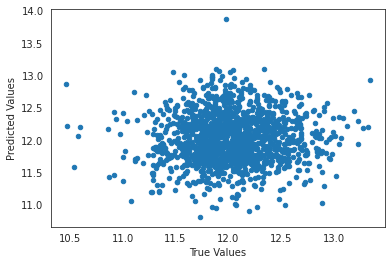

In [41]:
pd.DataFrame({"True Values" : y_test, "Predicted Values": pred}).plot.scatter(x='True Values', y='Predicted Values');

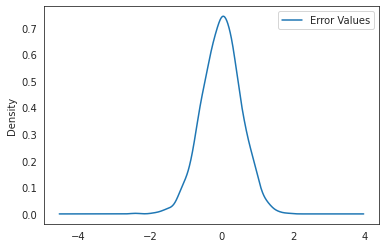

In [42]:
pd.DataFrame({"Error Values": (y_test - pred)}).plot.kde();

In [43]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print("Train Set Predictions are:\n----------------------------")
print_evaluate(y_train, train_pred)
print("Test Set Predictions are:\n----------------------------")
print_evaluate(y_test, test_pred)

Train Set Predictions are:
----------------------------
MAE: 0.0921588483645361
MSE: 0.017928877582643943
RMSE: 0.133898758704642
R2 Square: 0.8856353802792083
----------------------------
Test Set Predictions are:
----------------------------
MAE: 0.42809050602750554
MSE: 0.2933253533651427
RMSE: 0.5415951932625904
R2 Square: -0.8710620526822961
----------------------------


In [44]:
results_df_2 = pd.DataFrame(data = [["Robust Regression", *evaluate(y_test, test_pred), cross_val(RANSACRegressor())]], columns = ["Model", "MAE", "MSE", "RMSE", "R2 Square", "Cross Validation"])

results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.432940,0.300078,0.547794,-0.914136,0.901226
1,Robust Regression,0.428091,0.293325,0.541595,-0.871062,0.885017


In [45]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=42)
model.fit(X_train, y_train)

Ridge(alpha=100, random_state=42, solver='cholesky', tol=0.0001)

In [46]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print("Train Set Predictions are:\n----------------------------")
print_evaluate(y_train, train_pred)
print("Test Set Predictions are:\n----------------------------")
print_evaluate(y_test, test_pred)

Train Set Predictions are:
----------------------------
MAE: 0.08488874608323674
MSE: 0.014758072849151845
RMSE: 0.12148280886261992
R2 Square: 0.9058612910136178
----------------------------
Test Set Predictions are:
----------------------------
MAE: 0.43052659794833376
MSE: 0.29578429195674455
RMSE: 0.5438605445854153
R2 Square: -0.8867471158240934
----------------------------


In [47]:
results_df_2 = pd.DataFrame(data = [["Ridge Regression", *evaluate(y_test, test_pred), cross_val(Ridge())]], columns = ["Model", "MAE", "MSE", "RMSE", "R2 Square", "Cross Validation"])

results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.432940,0.300078,0.547794,-0.914136,0.901226
1,Robust Regression,0.428091,0.293325,0.541595,-0.871062,0.885017
2,Ridge Regression,0.430527,0.295784,0.543861,-0.886747,0.901246


In [48]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.1,
              precompute=True,
              positive=True,
              selection='random',
              random_state=42)

model.fit(X_train, y_train)


Lasso(alpha=0.1, positive=True, precompute=True, random_state=42,
      selection='random')

In [49]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print("Train Set Predictions are:\n----------------------------")
print_evaluate(y_train, train_pred)
print("Test Set Predictions are:\n----------------------------")
print_evaluate(y_test, test_pred)

Train Set Predictions are:
----------------------------
MAE: 0.1511449263085456
MSE: 0.04290987295979107
RMSE: 0.2071469839505057
R2 Square: 0.7262867527153753
----------------------------
Test Set Predictions are:
----------------------------
MAE: 0.36791059544039917
MSE: 0.2149486667854633
RMSE: 0.46362556744151123
R2 Square: -0.3711133016049921
----------------------------


In [50]:
results_df_2 = pd.DataFrame(data = [["Lasso Regression", *evaluate(y_test, test_pred), cross_val(Lasso())]], columns = ["Model", "MAE", "MSE", "RMSE", "R2 Square", "Cross Validation"])

results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.432940,0.300078,0.547794,-0.914136,0.901226
1,Robust Regression,0.428091,0.293325,0.541595,-0.871062,0.885017
2,Ridge Regression,0.430527,0.295784,0.543861,-0.886747,0.901246
3,Lasso Regression,0.367911,0.214949,0.463626,-0.371113,-0.006820


In [51]:
from sklearn.linear_model import ElasticNet

model = ElasticNet(alpha=0.1,
                   l1_ratio=0.9,
                   selection='random',
                   random_state=42)

model.fit(X_train, y_train)

ElasticNet(alpha=0.1, l1_ratio=0.9, random_state=42, selection='random')

In [52]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print("Train Set Predictions are:\n----------------------------")
print_evaluate(y_train, train_pred)
print("Test Set Predictions are:\n----------------------------")
print_evaluate(y_test, test_pred)

Train Set Predictions are:
----------------------------
MAE: 0.1437088945760815
MSE: 0.039324207312227806
RMSE: 0.19830332148561658
R2 Square: 0.7491589758280173
----------------------------
Test Set Predictions are:
----------------------------
MAE: 0.37252424188570027
MSE: 0.22047028257694415
RMSE: 0.46954263126679363
R2 Square: -0.40633455220064163
----------------------------


In [53]:
results_df_2 = pd.DataFrame(data = [["Elastic Net Regression", *evaluate(y_test, test_pred), cross_val(ElasticNet())]], columns = ["Model", "MAE", "MSE", "RMSE", "R2 Square", "Cross Validation"])

results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.432940,0.300078,0.547794,-0.914136,0.901226
1,Robust Regression,0.428091,0.293325,0.541595,-0.871062,0.885017
2,Ridge Regression,0.430527,0.295784,0.543861,-0.886747,0.901246
3,Lasso Regression,0.367911,0.214949,0.463626,-0.371113,-0.006820
4,Elastic Net Regression,0.372524,0.220470,0.469543,-0.406335,-0.006820


In [54]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)

X_train_2d = poly_reg.fit_transform(X_train)
X_test_2d = poly_reg.transform(X_test)

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train_2d, y_train)



LinearRegression(normalize=True)

In [55]:
train_pred = lin_reg.predict(X_train_2d)
test_pred = lin_reg.predict(X_test_2d)

print("Train Set Predictions are:\n----------------------------")
print_evaluate(y_train, train_pred)
print("Test Set Predictions are:\n----------------------------")
print_evaluate(y_test, test_pred)

Train Set Predictions are:
----------------------------
MAE: 0.056237605692763676
MSE: 0.006211143003989731
RMSE: 0.0788108051220753
R2 Square: 0.9603803972441431
----------------------------
Test Set Predictions are:
----------------------------
MAE: 98414986843.0311
MSE: 2.330847881393205e+24
RMSE: 1526711459770.0527
R2 Square: -1.486799886684466e+25
----------------------------


In [56]:
results_df_2 = pd.DataFrame(data = [["Polynomial Regression", *evaluate(y_test, test_pred), 0]], columns = ["Model", "MAE", "MSE", "RMSE", "R2 Square", "Cross Validation"])

results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,4.329396e-01,3.000780e-01,5.477938e-01,-9.141360e-01,0.901226
1,Robust Regression,4.280905e-01,2.933254e-01,5.415952e-01,-8.710621e-01,0.885017
2,Ridge Regression,4.305266e-01,2.957843e-01,5.438605e-01,-8.867471e-01,0.901246
3,Lasso Regression,3.679106e-01,2.149487e-01,4.636256e-01,-3.711133e-01,-0.006820
4,Elastic Net Regression,3.725242e-01,2.204703e-01,4.695426e-01,-4.063346e-01,-0.006820
5,Polynomial Regression,9.841499e+10,2.330848e+24,1.526711e+12,-1.486800e+25,0.000000


In [57]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(n_iter_no_change=250,
                       penalty=None,
                       eta0 = 0.001,
                       max_iter=100000)

sgd_reg.fit(X_train, y_train)


SGDRegressor(eta0=0.001, max_iter=100000, n_iter_no_change=250, penalty=None)

In [58]:
train_pred = sgd_reg.predict(X_train)
test_pred = sgd_reg.predict(X_test)

print("Train Set Predictions are:\n----------------------------")
print_evaluate(y_train, train_pred)
print("Test Set Predictions are:\n----------------------------")
print_evaluate(y_test, test_pred)

Train Set Predictions are:
----------------------------
MAE: 0.08437015606240933
MSE: 0.014527906929828253
RMSE: 0.1205317673056703
R2 Square: 0.9073294720369302
----------------------------
Test Set Predictions are:
----------------------------
MAE: 0.4333149687977067
MSE: 0.3002664061058169
RMSE: 0.5479656979280882
R2 Square: -0.9153375994079658
----------------------------


In [59]:
results_df_2 = pd.DataFrame(data = [["Stochastic Gradient Regression", *evaluate(y_test, test_pred), cross_val(SGDRegressor())]], columns = ["Model", "MAE", "MSE", "RMSE", "R2 Square", "Cross Validation"])

results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,4.329396e-01,3.000780e-01,5.477938e-01,-9.141360e-01,0.901226
1,Robust Regression,4.280905e-01,2.933254e-01,5.415952e-01,-8.710621e-01,0.885017
2,Ridge Regression,4.305266e-01,2.957843e-01,5.438605e-01,-8.867471e-01,0.901246
3,Lasso Regression,3.679106e-01,2.149487e-01,4.636256e-01,-3.711133e-01,-0.006820
4,Elastic Net Regression,3.725242e-01,2.204703e-01,4.695426e-01,-4.063346e-01,-0.006820
5,Polynomial Regression,9.841499e+10,2.330848e+24,1.526711e+12,-1.486800e+25,0.000000
6,Stochastic Gradient Regression,4.333150e-01,3.002664e-01,5.479657e-01,-9.153376e-01,0.899352
